
## Tuyere model for PDF shaping (894 samples)

This uses the new object oriented class for PDF shaping.

This model uses the CFD tuyere data with 894 samples

## Web application 6 inputs and 1 output

Run interactively on the web at: 
    
## Inputs

(1, 'i_h2_inj_kg_thm')

(2, 'i_pul_coal_inj_kg_thm')

(3, 'i_nat_gas_inj_kg_thm')

(4, 'i_nat_gas_t_k')

(5, 'i_o2_vol_perce')

(6, 'i_hot_blast_temp_k')



## Outputs



(9, 'o_tuyere_exit_velo_m_s')




## Imports


In [16]:


import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch


import torch.optim as optim


from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)


In [17]:

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import onnxmltools
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost)
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster


from zipfile import ZipFile
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes)


# Import the ONNX runtime environment
import onnxruntime as rt


In [18]:

import PDFshapingUtils as PDF_tk



## Instantiate PDF shaping and regression class


In [19]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()



## Initialize parameters


In [20]:

PDFshapingOBJ.N_error_range = 5         ## 20
PDFshapingOBJ.mean_impulse  = 0.0       ## -7.0      ## 0.0
PDFshapingOBJ.std_impulse   = 0.001     ## 1.0
PDFshapingOBJ.kde_std       = 0.5       ## 0.1       ## 0.5      ## 3.0  ## smaller is better approximation?
PDFshapingOBJ.bandwidth     = 0.2       ## 0.2->more jagged, 2.0->more smooth


In [21]:

PDFshapingOBJ.initializeImpulseGaussian()



## Run checks


In [22]:

## print(PDFshapingOBJ.x_range_impulse_func )
## print(PDFshapingOBJ.impulse_func_vector_vals )
## print(PDFshapingOBJ.quadratic_weights)
print(PDFshapingOBJ.x_range_impulse_func.shape )
print(PDFshapingOBJ.impulse_func_vector_vals.shape )
print(PDFshapingOBJ.quadratic_weights.shape)
 
print( sum(PDFshapingOBJ.impulse_func_vector_vals) )      ## should add up to 100 (i.e. 1.0 prob density)


torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
tensor(100.0000)


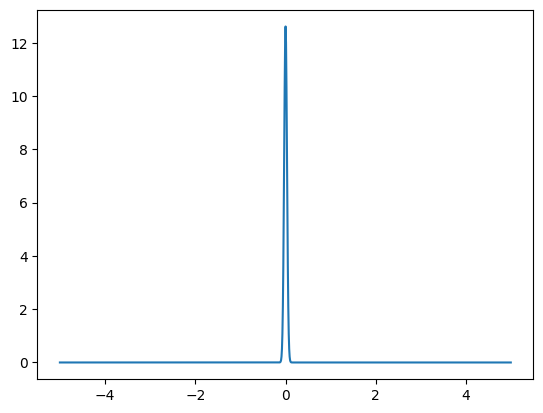

In [23]:

plt.plot(PDFshapingOBJ.x_range_impulse_func, PDFshapingOBJ.impulse_func_vector_vals)
plt.show()



## RUN KDE test


In [24]:

## PDFshapingOBJ.test_torchKDE_with_fake_data()



## Load Data


In [25]:

PDFshapingOBJ.read_csv_file_with_pandas('CFD.ForRelease.12.2023.csv')


In [26]:

PDFshapingOBJ.CFD_raw_data


,index,i_h2_inj_kg_thm,i_pul_coal_inj_kg_thm,i_nat_gas_inj_kg_thm,i_nat_gas_t_k,i_o2_vol_perce,i_hot_blast_temp_k,i_ore_moisture_weight_perce,i_ore_weight_kg,o_tuyere_exit_velo_m_s,...,o_shaft_co_utiliz,o_shaft_h2_utiliz,o_shaft_top_gas_temp_c,o_shaft_press_drop_pa,o_shaft_coke_rate_kg_thm,o_shaft_cohesive_zone_tip_height_m,o_shaft_co_v_perc,o_shaft_co2_v_perc,o_shaft_h2_v_perce,o_shaft_n2_v_perc
0,1,0.000000,0.0,0.1895,0.6,0.7,0.983042,0.777778,0.623735,133.48650,...,47.20085,42.99392,118.8785,108434.33,0.00000,31.83963,0.217192,0.194163,0.043833,0.544812
1,2,0.000000,0.0,0.1895,0.6,0.8,0.983042,0.777778,0.636403,133.09000,...,49.15851,44.99764,95.7563,108381.02,18.08450,31.83963,0.226098,0.218613,0.040343,0.514946
2,3,0.000000,0.0,0.1895,0.6,0.9,0.983042,0.777778,0.649070,132.77200,...,49.30602,44.48147,84.8519,112232.83,37.36395,31.75963,0.241959,0.235334,0.037726,0.484981
3,4,0.000000,0.0,0.1895,0.6,1.0,0.983042,0.777778,0.661738,132.33100,...,47.22992,46.37194,66.3779,118634.40,58.84995,31.55962,0.267702,0.239597,0.035448,0.457252
4,5,0.000000,0.0,0.3500,0.6,0.7,0.983042,0.777778,0.676050,135.09680,...,46.66340,41.83302,130.4139,106947.64,-40.16470,31.75963,0.211014,0.184613,0.071127,0.533246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,890,0.666667,0.0,0.3500,0.6,0.9,0.983042,0.777778,0.748919,152.86294,...,48.11546,42.78430,122.0079,137423.80,-41.14660,31.80024,0.213421,0.197917,0.122270,0.466392
890,891,1.000000,0.0,0.3000,0.6,0.9,0.983042,0.777778,0.756389,164.16174,...,47.40511,41.99833,132.4238,146622.00,-43.00085,31.88024,0.209051,0.188423,0.143751,0.458775
891,892,0.333333,0.0,0.5000,0.6,0.9,0.983042,0.777778,0.774045,149.15341,...,48.24004,41.11932,121.1668,128838.00,-53.28150,31.80024,0.216270,0.201562,0.117991,0.464177
892,893,0.666667,0.0,0.4500,0.6,0.9,0.983042,0.777778,0.781514,159.36325,...,47.21544,39.43614,129.2255,129115.30,-52.37820,31.76024,0.213118,0.190633,0.142068,0.454181


In [27]:

PDFshapingOBJ.print_headers_list()


['index', 'i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_hot_blast_temp_k', 'i_ore_moisture_weight_perce', 'i_ore_weight_kg', 'o_tuyere_exit_velo_m_s', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
23
(0, 'index')
(1, 'i_h2_inj_kg_thm')
(2, 'i_pul_coal_inj_kg_thm')
(3, 'i_nat_gas_inj_kg_thm')
(4, 'i_nat_gas_t_k')
(5, 'i_o2_vol_perce')
(6, 'i_hot_blast_temp_k')
(7, 'i_ore_moisture_weight_perce')
(8, 'i_ore_weight_kg')
(9, 'o_tuyere_exit_velo_m_s')
(10, 'o_raceway_flame_temp_k')
(11, 'o_raceway_coal_burn_perce')
(12, 'o_raceway_volume_m')
(13, 'o_shaft_co_utiliz')
(14, 'o_shaft_h2_utiliz')
(15, 'o_shaft_top_gas_temp_c')
(16, 'o_shaft_press_drop_pa')
(17, 'o_s

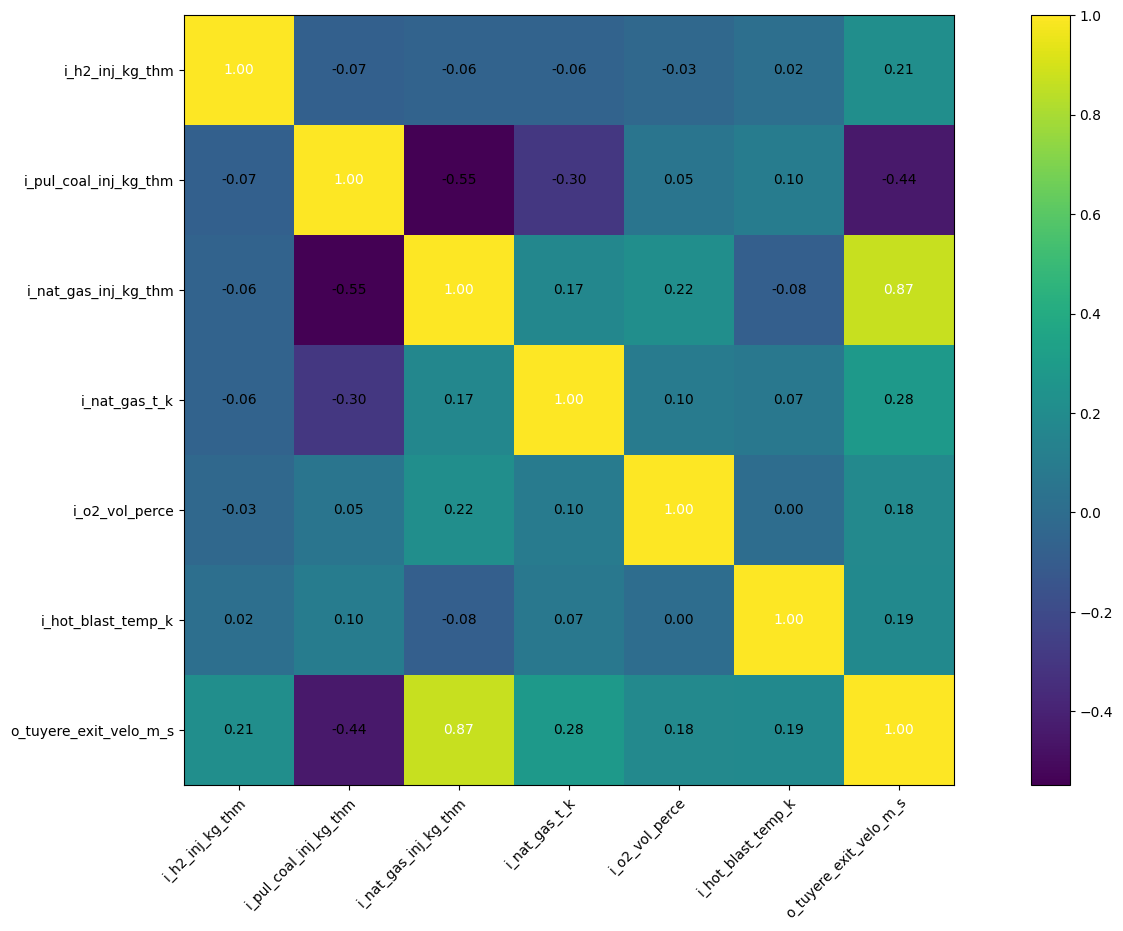

In [28]:

PDFshapingOBJ.list_of_selected_column_names = ['i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 
                    'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_hot_blast_temp_k', 
                    'o_tuyere_exit_velo_m_s']

PDFshapingOBJ.print_correlation_coefficients()


In [29]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[  1.           0.           0.         ...   0.1941631    0.0438327
    0.5448123 ]
 [  2.           0.           0.         ...   0.2186134    0.04034286
    0.5149459 ]
 [  3.           0.           0.         ...   0.2353341    0.03772617
    0.4849808 ]
 ...
 [892.           0.33333333   0.         ...   0.2015624    0.1179911
    0.4641767 ]
 [893.           0.66666667   0.         ...   0.1906331    0.1420678
    0.4541806 ]
 [894.           1.           0.         ...   0.1820335    0.1569839
    0.4515486 ]]
(894, 23)



## Select inputs and outputs


In [31]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs = [ 1, 2, 3, 4, 5, 6 ] , 
                   outputs= [ 9 ]   
)


6
1


In [32]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)


(894, 6)
(894, 1)


In [33]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [34]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(715, 6)
(179, 6)
(715, 1)
(179, 1)


In [35]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [36]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [37]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl



## NN architectures


In [39]:

#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 1) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled


In [40]:

#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(6, 1)       
        
        ## F2
        self.f2_linear1 = nn.Linear(6, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 1)       
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    



## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear


In [41]:

def fit_y_scaled(num_epochs, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
            
            
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(
            torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()   )
            )
        )
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,           PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy()  ))
    


In [42]:

PDFshapingOBJ.the_string           = "No_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "tuyere_exit_velo_m_s"


0  loss=  tensor(1.8954, grad_fn=<MseLossBackward0>)
200  loss=  tensor(0.1363, grad_fn=<MseLossBackward0>)
400  loss=  tensor(0.0174, grad_fn=<MseLossBackward0>)
600  loss=  tensor(0.0122, grad_fn=<MseLossBackward0>)
800  loss=  tensor(0.0486, grad_fn=<MseLossBackward0>)
1000  loss=  tensor(0.0162, grad_fn=<MseLossBackward0>)
1200  loss=  tensor(0.0098, grad_fn=<MseLossBackward0>)
1400  loss=  tensor(0.0119, grad_fn=<MseLossBackward0>)
1600  loss=  tensor(0.0241, grad_fn=<MseLossBackward0>)
1800  loss=  tensor(0.0111, grad_fn=<MseLossBackward0>)


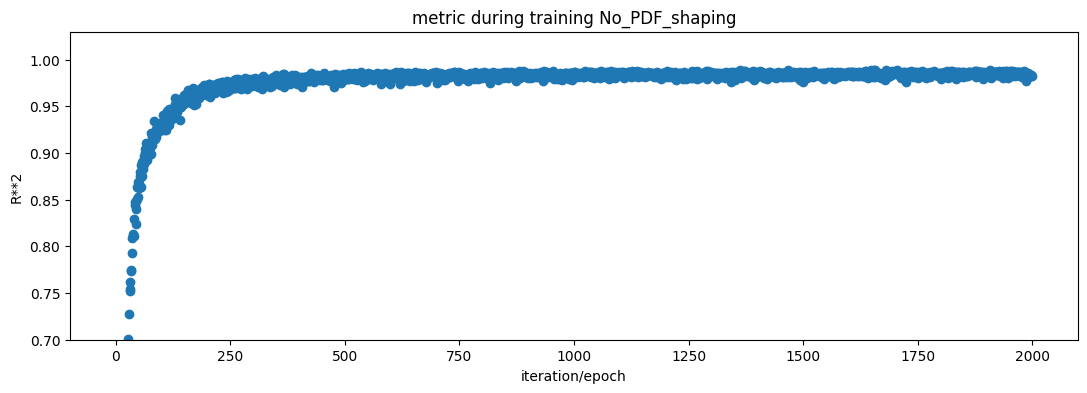

Training loss: tensor(0.0157, grad_fn=<MseLossBackward0>)
Training R**2: 0.9836677729054464
Test loss - scaled: tensor(0.0137, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(0.7994, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.9874643885522603
Testing R**2 - descaled: 0.9874643918823387
*****
*****
Testing R**2 - Output: 0 o_tuyere_exit_velo_m_s 0.9874643918823387


In [43]:

model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)

opt = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(PDFshapingOBJ.N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,         PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,       PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()    ))

PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [44]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])


**************************************************
preds, real
(162.97475, 161.81998)
**************************************************
preds, real
(137.08684, 137.5515)
**************************************************
preds, real
(128.23999, 128.62132)
**************************************************
preds, real
(150.85394, 149.98244)
**************************************************
preds, real
(137.48921, 137.5515)
**************************************************
preds, real
(145.30148, 147.70348)
**************************************************
preds, real
(130.0295, 129.11511)
**************************************************
preds, real
(130.18869, 129.85136)
**************************************************
preds, real
(152.88403, 152.41486)
**************************************************
preds, real
(136.8512, 136.73552)
**************************************************
preds, real
(131.25706, 130.5723)
**************************************************
preds, r

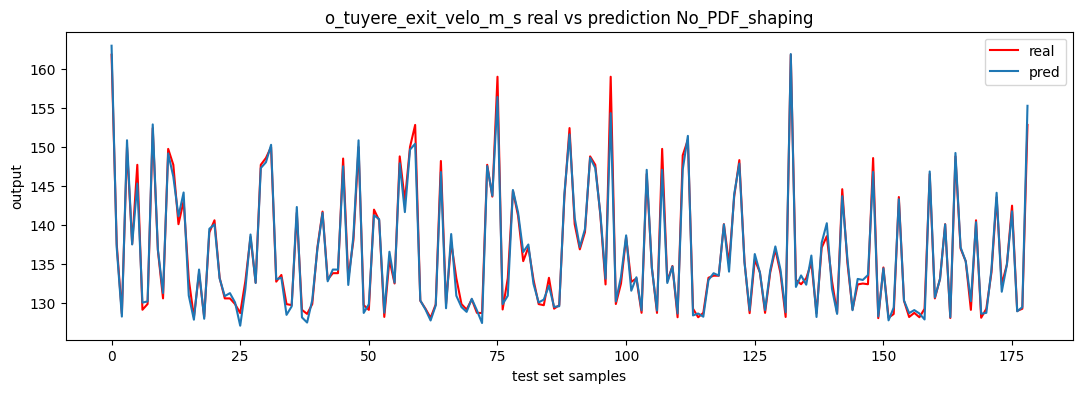

/Users/user/Desktop/DOE_CIVS/experiments/2023august/singleOutput/PDFshapingUtils.py:353: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


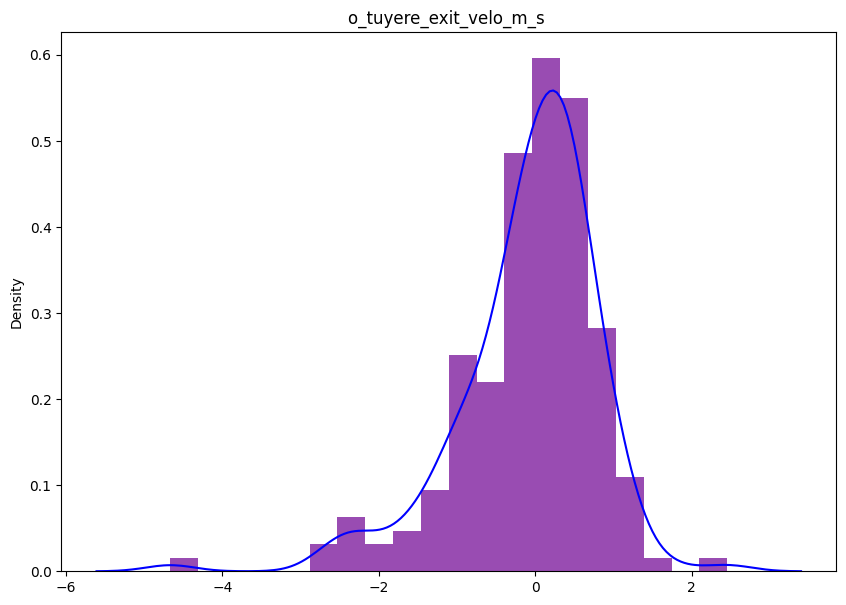

In [45]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )



## XGBoost


In [46]:

regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)


In [47]:

regressor.fit(PDFshapingOBJ.X_train, PDFshapingOBJ.y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [48]:

print( len(PDFshapingOBJ.X_train  ))
print( len(PDFshapingOBJ.y_train  ))
  



715
715


In [49]:

columns_thing = ['i_h2_inj_kg_thm', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 
                 'i_o2_vol_perce', 'i_hot_blast_temp_k', ]



pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=columns_thing)


,i_h2_inj_kg_thm,i_pul_coal_inj_kg_thm,i_nat_gas_inj_kg_thm,i_nat_gas_t_k,i_o2_vol_perce,i_hot_blast_temp_k
0,0.266127,0.045069,0.381372,0.159427,0.010488,0.137517


In [50]:

y_pred = regressor.predict(PDFshapingOBJ.X_test )


In [51]:

y_pred


array([161.82625, 137.243  , 128.6424 , 149.81741, 137.243  , 147.86815,
       129.14726, 129.86157, 152.43346, 136.71959, 130.57689, 149.5304 ,
       147.86815, 139.68106, 143.06194, 133.01532, 128.16081, 133.83388,
       128.20097, 139.15248, 140.2524 , 133.24127, 130.57689, 130.57689,
       129.86157, 128.724  , 132.68246, 138.51566, 132.59879, 147.86815,
       149.00647, 149.81741, 132.6671 , 133.52365, 129.80489, 129.72755,
       141.60822, 129.06049, 128.61632, 129.80489, 137.16722, 141.74535,
       132.90062, 133.83388, 133.83388, 148.9005 , 132.94835, 138.11092,
       149.81741, 129.72755, 129.06049, 142.07724, 140.2524 , 128.20097,
       135.62128, 132.50076, 149.221  , 143.06194, 149.96025, 153.05817,
       130.22203, 129.23793, 128.0639 , 129.81136, 148.7386 , 129.80489,
       137.84741, 133.24222, 129.86157, 129.17334, 130.40135, 128.73557,
       128.724  , 147.86815, 143.52342, 158.81364, 129.17334, 133.24222,
       144.13864, 141.11855, 135.36073, 137.14867, 

In [52]:

mean_squared_error(PDFshapingOBJ.y_test , y_pred)


0.19532284

In [53]:

r2_score( PDFshapingOBJ.y_test, y_pred )


0.9969204902193258

In [54]:

len(y_pred) 


179

In [55]:

list_preds = []
list_reals = []

print( "preds, real"   )
  
for j in range(   len(y_pred)    ):
    print(   y_pred[j], PDFshapingOBJ.y_test[j][0]   )
    
    list_preds.append(   y_pred[j]   )
    list_reals.append(  PDFshapingOBJ.y_test[j][0]   )


preds, real
161.82625 161.81998
137.243 137.5515
128.6424 128.62132
149.81741 149.98244
137.243 137.5515
147.86815 147.70348
129.14726 129.11511
129.86157 129.85136
152.43346 152.41486
136.71959 136.73552
130.57689 130.5723
149.5304 149.7471
147.86815 147.70348
139.68106 140.08952
143.06194 143.07054
133.01532 133.0403
128.16081 128.18655
133.83388 133.80692
128.20097 128.19148
139.15248 139.01598
140.2524 140.59135
133.24127 133.21564
130.57689 130.5723
130.57689 130.5723
129.86157 129.84276
128.724 128.69382
132.68246 132.772
138.51566 138.4379
132.59879 132.58759
147.86815 147.70348
149.00647 148.57646
149.81741 149.98244
132.6671 132.7186
133.52365 133.5776
129.80489 129.83923
129.72755 129.71217
141.60822 141.5601
129.06049 129.10246
128.61632 128.58289
129.80489 129.83923
137.16722 137.0987
141.74535 141.70135
132.90062 132.986
133.83388 133.80692
133.83388 133.80692
148.9005 148.50858
132.94835 133.09
138.11092 138.02988
149.81741 149.98244
129.72755 129.71217
129.06049 129.1024

In [56]:
len( list_preds )

179

In [57]:

len( list_reals )


179

In [58]:

PDFshapingOBJ.the_string           = "XGBoost"
PDFshapingOBJ.furnace_model_name   = "tuyere_exit_velo_m_s"


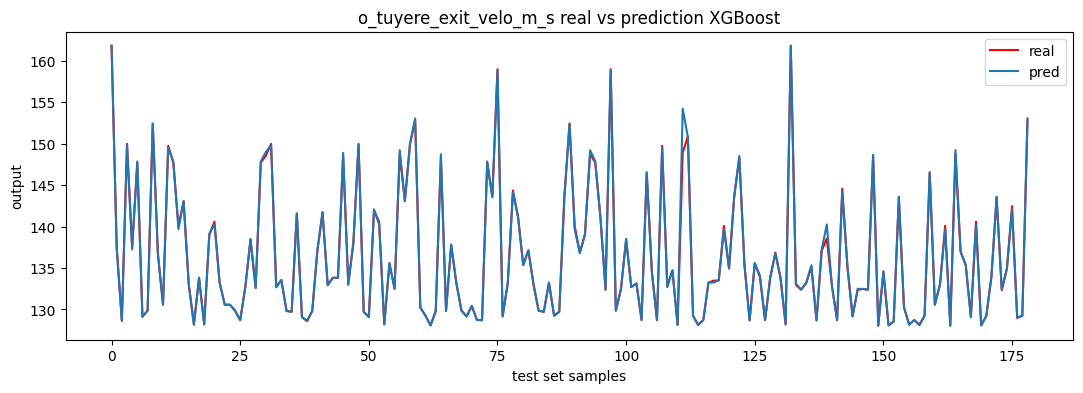

/Users/user/Desktop/DOE_CIVS/experiments/2023august/singleOutput/PDFshapingUtils.py:353: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


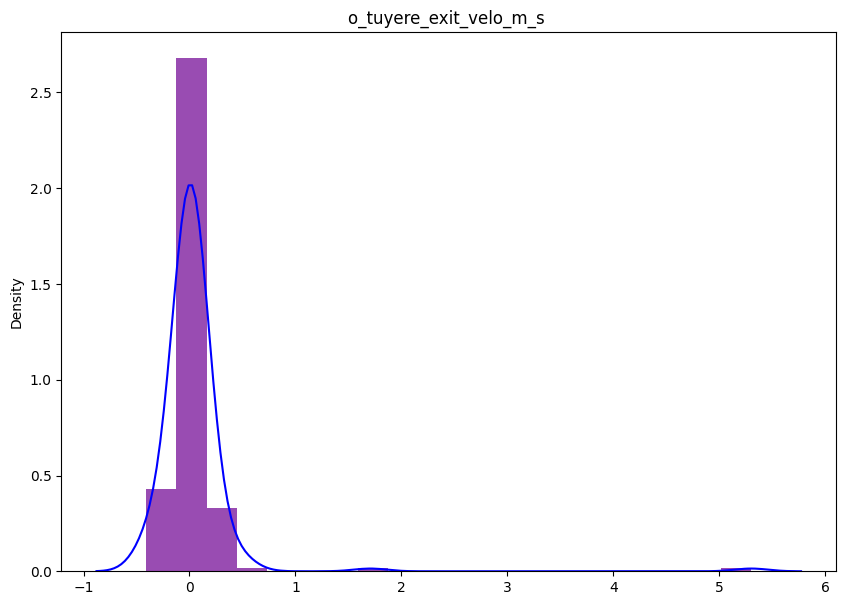

In [59]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )
